In [1]:
import gym
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
#for using gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('MountainCarContinuous-v0')
print(env.action_space, env.observation_space)
env.seed(101)
np.random.seed(101)

/home/oxygen/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Box(1,) Box(2,)


In [4]:
class Agent(nn.Module):
    def __init__(self, env, action_space, state_space):
        super(Agent, self).__init__()
        self.env = env
        self.a_s = action_space
        self.s_s = state_space
        self.h_s = 16
        self.fc1 = nn.Linear(self.s_s, self.h_s).to(device)
        self.fc2 = nn.Linear(self.h_s, self.a_s).to(device)
    
    def get_wights_dim(self):
        return (self.s_s+1)*self.h_s + (self.h_s+1)*self.a_s

    def adjust_to_weights(self,weights):
        end = self.s_s*self.h_s + self.h_s
        fc1_w = torch.from_numpy(weights[:self.s_s*self.h_s]).reshape(self.s_s, self.h_s)
        fc1_b = torch.from_numpy(weights[self.s_s*self.h_s:end])
        fc2_w = torch.from_numpy(weights[end:end+self.h_s*self.a_s]).reshape(self.h_s, self.a_s)
        fc2_b = torch.from_numpy(weights[end+self.h_s*self.a_s:])
        #copying weights and bias
        self.fc1.weight.data.copy_(fc1_w.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_w.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
            
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x.cpu().data
        
    def evaluate(self, weight, itera):
        self.adjust_to_weights(weight)
        state = self.env.reset()
        scores = 0.0
        for _ in range(itera):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            next_state, reward, done, _ = self.env.step(action)
            scores += reward
            state = next_state
            if done:
                break
        return scores

agent = Agent(env, 1,2)

In [5]:
def cross_entropy(n_episode = 100, n_iter=1000, batch_per_epi=50, prob_selection=20, sigma = 0.5):
    best_weight = sigma*np.random.randn(agent.get_wights_dim())
    number_of_selection = int(prob_selection*batch_per_epi/100.0)
    scores_deque = deque(maxlen=100)
    for i in range(n_episode):
        memory = [best_weight + sigma*np.random.randn(agent.get_wights_dim()) for _ in range(batch_per_epi)]
        reward = [agent.evaluate(weight, n_iter) for weight in memory]
        arranged_index = np.array(reward).argsort()[-number_of_selection:]
        weights = [memory[j] for j in arranged_index]  #collected top n weights according to reward
        #best_weight = (sum(weights)/number_of_selection)
        best_weight = np.array(weights).mean(axis = 0)
        reward = agent.evaluate(best_weight, n_iter)
        scores_deque.append(reward)
        #print(agent.fc1.weight)
        torch.save(agent.state_dict(), 'checkpoint_own.pth')
        print(' Average Score {}'.format(reward))
        if scores_deque[-1] >= 90.0:
            print("Solved ")
            break
            
        #averaging weights 
cross_entropy()

/home/oxygen/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


 Average Score -5.022840426837904
 Average Score -0.4405517880810916
 Average Score -0.5454038933958927
 Average Score -0.6527626100473278
 Average Score -2.6957201970963407
 Average Score -0.9530679725511854
 Average Score -0.09952659425288421
 Average Score -0.10246435541237935
 Average Score -1.4752855993972913
 Average Score -2.441910938825497
 Average Score -5.2393235803384615
 Average Score -17.8767979698008
 Average Score -3.3377305966192603
 Average Score -2.512417888983384
 Average Score -0.40997017291483656
 Average Score -0.022365840399915203
 Average Score -4.443952108452526
 Average Score -4.437807123704333
 Average Score -17.007662968575367
 Average Score -9.852323082905519
 Average Score -12.055436396434747
 Average Score -2.469176989623034
 Average Score -15.518621880260744
 Average Score -8.338004384340454
 Average Score -0.028680089574990707
 Average Score -2.321956413558945
 Average Score -1.1240958879488454
 Average Score -0.5360040315577659
 Average Score -1.743046

/home/oxygen/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


677


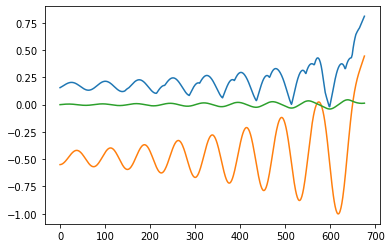

In [22]:
agent.load_state_dict(torch.load('checkpoint_own.pth'))
actions = deque(maxlen=700)
states1 = deque(maxlen=700)
states2 = deque(maxlen=700)
count = 0
state = env.reset()
while True:
    count += 1
    state = torch.from_numpy(state).float().to(device)
    states1.append(float(state[0]))
    states2.append(float(state[1]))
    with torch.no_grad():
        action = agent(state)
        actions.append(float(action))
    env.render()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

print(count)
env.close()
plt.plot(actions)
plt.plot(states1)
plt.plot(states2)
plt.show()